In [1]:
# keras
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding

# sklearn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re


from sklearn.manifold import TSNE



In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
train.shape

(1306122, 3)

In [ ]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


In [ ]:
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

In [ ]:
stopwords = list(nltk.corpus.stopwords.words('english'))

In [ ]:
%%time
# remove stop words and lower all characters
clean_questions = [' '.join(w for w in nltk.word_tokenize(q.lower()) if w not in stopwords) for q in clean_questions]

In [ ]:
train['clean_question'] = list(clean_questions)

In [ ]:
train.head()

In [ ]:
X = train['clean_question']
y = train.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [ ]:
%%time
INPUT_LEN = 80

# Keep most frequent words upto vocab limit.
tokenizer = Tokenizer(num_words = 100000)
tokenizer.fit_on_texts(X_train) # assign unique feature number to each token.

Train_sequences = tokenizer.texts_to_sequences(X_train) # convert tokens in each question to feature numbers.
X_train_data = pad_sequences(Train_sequences, maxlen=INPUT_LEN) # Make all questions have the same number of features

Test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_data = pad_sequences(Test_sequences, maxlen=INPUT_LEN)


In [ ]:
X_train[1]

In [ ]:
Train_sequences[1]

In [46]:
X_train_data[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   875,  2272, 21592])

In [ ]:
len(tokenizer.word_counts)

In [ ]:
# Tunning parameters
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [1]:
## Network architecture
model = Sequential() # layers are connected sequentially, layers can only communicate with it's adjacent layer

#convert each word to a vector position based on meaning, dense representation.

model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN)) 

#dropouts randomly exclude units from activation or weight update, to reduce overfitting.
# dropout is for input layer, recurrent_dropout for internal layers.
# Dropout prevent each node to become too specialised.
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))

model.add(Dense(1, activation='sigmoid')) # define final NN layer(output), with single node (0 or 1), sigmoid activation.
# Binary_crossentropy, for 0-1 classficiation, is a log function that punish predictions further from the actual value.
# Adam maintain per-parameter learning rate (good for sparse, NLP) and adapted learning rate based on recent changes in gradient(good for noisy data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit the model
model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

NameError: name 'Sequential' is not defined

In [ ]:
%%time
y_pred = model.predict(X_test_data, workers=6)

In [ ]:
y_predRound = [ 1 if y >= 0.5 else 0  for y in y_pred]

In [ ]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

In [150]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in proba_list]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test_raw,  y_predRound))
    precision_list.append(precision_score(y_test_raw,  y_predRound))
    f1_list.append(f1_score(y_test_raw,  y_predRound))

In [151]:
raw_combined_score = pd.DataFrame(index=threshold_list)
raw_combined_score['F1 Score'] = f1_list
raw_combined_score['Precision'] = precision_list
raw_combined_score['Recall'] = recall_list

In [154]:
LSTM_combined_score.to_pickle('./LSTM_combined_score.pkl')

In [155]:
LSTM_combined_score = pd.read_pickle('./LSTM_combined_score.pkl')

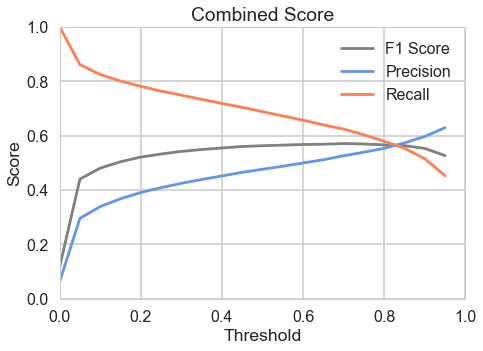

In [173]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=raw_combined_score.index, y=raw_combined_score['F1 Score'], color='grey')
sns.lineplot(x=raw_combined_score.index, y=raw_combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=raw_combined_score.index, y=raw_combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Combined Score')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(raw_combined_score.columns)




### 1D convolutional layer before LSTM

In [79]:
# Tunning parameters
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100
LSTM_UNITS = 100
DROP = 0.4
RE_DROP = 0.4
FILTERS = 128
KERNEL = 1
POOL_SIZE = 2

In [80]:
%%time
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
    model_conv.add(Dropout(DROP))
    model_conv.add(Conv1D(FILTERS, KERNEL, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=POOL_SIZE)) # Return max value from 4 adjacent values, reduce computational requirement and reduce overfitting.
    model_conv.add(LSTM(LSTM_UNITS))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
model_conv.fit(X_train_data, y_train, validation_split=0.4, epochs = 3)

# Reduced computation time to 1/4.

Train on 626938 samples, validate on 417959 samples
Epoch 1/3
626938/626938 [==============================] - 1991s 3ms/step - loss: 0.1290 - acc: 0.9496 - val_loss: 0.1219 - val_acc: 0.9523
Epoch 2/3
626938/626938 [==============================] - 1949s 3ms/step - loss: 0.1135 - acc: 0.9550 - val_loss: 0.1180 - val_acc: 0.9534
Epoch 3/3
626938/626938 [==============================] - 2169s 3ms/step - loss: 0.1080 - acc: 0.9575 - val_loss: 0.1212 - val_acc: 0.9530
Wall time: 1h 41min 54s


In [81]:
%%time
y_pred = model_conv.predict(X_test_data, workers=6)

Wall time: 4min 22s


In [90]:
y_predRound = [ 1 if y >= 0.1 else 0  for y in y_pred]

In [91]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

accuracy 0.930657479184611
              precision    recall  f1-score   support

           0       0.98      0.94      0.96    245063
           1       0.46      0.78      0.58     16162

   micro avg       0.93      0.93      0.93    261225
   macro avg       0.72      0.86      0.77    261225
weighted avg       0.95      0.93      0.94    261225



array([[230482,  14581],
       [  3533,  12629]], dtype=int64)

### 1D convolutional layer after LSTM

In [ ]:
# Tunning parameters
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100
LSTM_UNITS = 100
DROP = 0.4
RE_DROP = 0.4
FILTERS = 128
KERNEL = 1
POOL_SIZE = 2

In [ ]:
%%time
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
    model_conv.add(LSTM(LSTM_UNITS))
    model_conv.add(Dropout(DROP))
    model_conv.add(Conv1D(FILTERS, KERNEL, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=POOL_SIZE))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
model_conv.fit(X_train_data, y_train, validation_split=0.4, epochs = 3)

# Reduced computation time to 1/4.

In [ ]:
%%time
y_pred = model_conv.predict(X_test_data, workers=6)

In [ ]:
y_predRound = [ 1 if y >= 0.1 else 0  for y in y_pred]

In [ ]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)